In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.patches
import seaborn as sns
import numpy as np
from scipy.stats import binom
from IPython.display import display
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import math

matplotlib.rcParams['font.family'] = "Clear Sans"
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
us_data_raw = pd.read_json('data/geometry-data.json')
print(len(us_data_raw))
us_data_raw.head()

15427


participant_number  accuracy  group_number  block        rt    trial_type  \
0               50010         1             1    NaN  3219.525  experimental   
1               50010         1             2    NaN  3460.660  experimental   
2               50010         0             1    NaN  3717.590       control   
3               50010         1             1    NaN  3130.385  experimental   
4               50010         1             2    NaN  3845.110  experimental   

        key  
0  training  
1  training  
2  training  
3  training  
4  training

In [4]:
group_info = pd.read_json('data/geometry-group-info.json')

group_info.head()


group_number correct_image  group_index  ppt_type       ppt_label  \
0             1       1_4.png            0  Training               1   
1             2       2_3.png            1  Training               2   
2             3       3_4.png            2  Topology           Holes   
3             4       4_1.png            3  Topology  Inside/Outside   
4             5       5_2.png            4  Topology         Closure   

  paper_category  paper_label  paper_number  correct_number  correct_index  
0       Training        Color             1               4              3  
1       Training  Orientation             2               3              2  
2       Topology        Holes             6               4              3  
3       Topology       Inside             3               1              0  
4       Topology      Closure             4               2              1

In [5]:
us_data_raw = us_data_raw.merge(group_info, on="group_number")

In [6]:

us_data_raw = us_data_raw[us_data_raw["paper_category"] != "Training"]
paper_category_order = ['Topology',
                        'Euclidean geometry',
                        'Geometrical figures',
                        'Symmetrical figures',
                        'Chiral figures',
                        'Metric properties',
                        'Geometrical transformations'
                       ]
us_data_raw['paper_category'] = pd.Categorical(us_data_raw['paper_category'], paper_category_order)
us_data = us_data_raw[us_data_raw["trial_type"] == "experimental"]
us_data.head()

participant_number  accuracy  group_number  block        rt  \
291               50010         1            27    1.0  6462.795   
293               50010         0            27    2.0  3817.640   
295               50007         1            27    1.0  1827.225   
297               50007         1            27    2.0  2967.305   
299               50011         1            27    1.0  4570.785   

       trial_type       key correct_image  group_index        ppt_type  \
291  experimental  geometry      27_4.png           26  Transformation   
293  experimental  geometry      27_4.png           26  Transformation   
295  experimental  geometry      27_4.png           26  Transformation   
297  experimental  geometry      27_4.png           26  Transformation   
299  experimental  geometry      27_4.png           26  Transformation   

                     ppt_label               paper_category  \
291  Axial Symmetry (vertical)  Geometrical transformations   
293  Axial Symmetry (vertical)  Geometrical transformations   
295  Axial Symmetry (vertical)  Geometrical transformations   
297  Axial Symmetry (vertical)  Geometrical transformations   
299  Axial Symmetry (vertical)  Geometrical transformations   

           paper_label  paper_number  correct_number  correct_index  
291  Vertical symmetry            42               4              3  
293  Vertical symmetry            42               4              3  
295  Vertical symmetry            42               4              3  
297  Vertical symmetry            42               4              3  
299  Vertical symmetry            42               4              3

In [7]:
by_category = us_data.groupby(['paper_category']).agg({'accuracy': 'mean'}).reset_index()
# reverse to get correct order in horizontal bar chart
by_category.head()

paper_category  accuracy
0             Topology  0.822443
1   Euclidean geometry  0.961648
2  Geometrical figures  0.912247
3  Symmetrical figures  0.820076
4       Chiral figures  0.821023

In [8]:
paper_category_cmap  = matplotlib.cm.get_cmap('tab10')
paper_category_colors = paper_category_cmap(range(len(by_category['paper_category'].to_numpy())))
paper_category_colors_dict = dict(zip(by_category['paper_category'], paper_category_colors))

def cat_colors(x):
    return paper_category_cmap(pd.Series(pd.Categorical(x, paper_category_order)).cat.codes)

<BarContainer object of 7 artists>

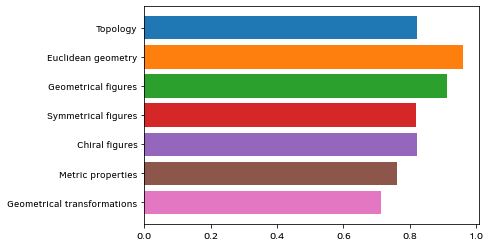

In [9]:
fig, ax = plt.subplots()
ax.barh(by_category['paper_category'][::-1], by_category['accuracy'][::-1], color=cat_colors(by_category['paper_category'][::-1]))


In [10]:
by_item = (us_data.groupby(['paper_number'])
           .agg({'accuracy':'mean', 'paper_category': 'first', 'paper_label': 'first'})
           .reset_index()
           .sort_values('accuracy'))
by_item.head()

paper_number  accuracy               paper_category  \
32            35  0.477273            Metric properties   
42            45  0.482955  Geometrical transformations   
38            41  0.625000  Geometrical transformations   
27            30  0.659091               Chiral figures   
33            36  0.681818            Metric properties   

               paper_label  
32  Center of quadilateral  
42                Rotation  
38     Horizontal symmetry  
27            Oblique axis  
33       Middle of segment

### What is chance probability?

First, we need the number of trials for each item, which is 176

In [11]:
n = us_data.groupby('paper_number').agg(dict(accuracy="count")).iloc[0]['accuracy']
n

176

There is a 0.95 chance that with probability of 0.5, the accuracy will be below 0.5625

In [12]:
null_accuracy = binom.ppf(0.95, n, 0.5) / n
null_accuracy

0.5625

Below are the individual accuraries, I printed these to make it easier to calculate the post-hoc power analyses.

In [13]:
us_data.groupby('paper_label').agg({'accuracy': 'mean'}).reset_index().sort_values(['accuracy'])

paper_label  accuracy
2          Center of quadilateral  0.477273
29                       Rotation  0.482955
16            Horizontal symmetry  0.625000
19              Middle of segment  0.681818
12                          Holes  0.687500
14         Homothecy (fixed size)  0.710227
15                Horizontal axis  0.727273
11               Fixed proportion  0.727273
36              Vertical symmetry  0.732955
13  Homothecy (fixed orientation)  0.744318
17            Increasing distance  0.744318
20                   Oblique axis  0.750000
21               Oblique symmetry  0.767045
28          Right angled triangle  0.812500
5                   Connectedness  0.812500
4                         Closure  0.812500
33                    Translation  0.812500
24                 Point symmetry  0.835227
9                    Equidistance  0.840909
31                         Square  0.852273
23                  Parallelogram  0.886364
34                      Trapezoid  0.892045
1                Center of circle  0.903409
35                  Vertical axis  0.922348
30                   Secant lines  0.931818
6                    Convex shape  0.937500
26                      Rectangle  0.943182
25                   Quadilateral  0.948864
7                           Curve  0.960227
27                    Right angle  0.960227
32                  Straight line  0.960227
0    Alignment of points in lines  0.965909
8                        Distance  0.965909
3                          Circle  0.965909
10           Equilateral triangle  0.971591
18                         Inside  0.977273
22                 Parallel lines  0.988636

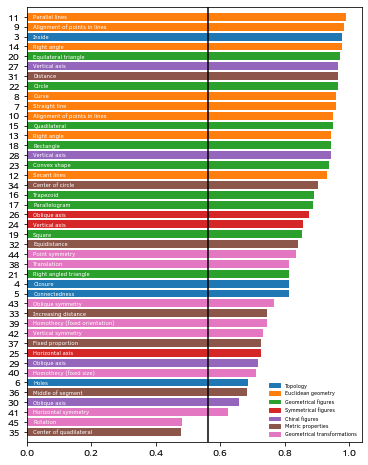

In [14]:
fig, ax = plt.subplots()

fig.set_figheight(8)

bars = ax.barh(range(len(by_item['paper_number'])), by_item['accuracy'], color=cat_colors(by_item['paper_category']))
ax.set_yticks(range(len(by_item['paper_number'])))
ax.set_yticklabels(by_item['paper_number'])
ax.set_ylim(-1, len(by_item))

legend_patches = []
for key, value in paper_category_colors_dict.items():
    legend_patches.append(matplotlib.patches.Patch(color=value, label=key))
    
ax.legend(handles=legend_patches, fontsize=5.5, frameon=False)

ax.axvline(null_accuracy, color="black")

for i in range(len(by_item)):
    ax.text(0.02, i - 0.2, by_item["paper_label"].iloc[i], color="white", fontsize=6)

Individual differences begin here

## Mental rotation

In [15]:
mrt_data = pd.read_json('data/mental_rotation-data.json')
mrt_data = mrt_data[mrt_data['stimulus_type'] == 'experimental']
mrt_data.head()


participant_number     target_img stimulus_type  number_correct   duration
13               50010   7_target.png  experimental               0  13584.125
14               50010  13_target.png  experimental               1  23923.895
15               50010  18_target.png  experimental               1  12555.825
16               50010  12_target.png  experimental               1  22872.065
17               50010   8_target.png  experimental               2  10715.465

In [16]:
mrt_data['accuracy'] = (mrt_data['number_correct'] == 2).astype('uint8')
mrt_data.head()

participant_number     target_img stimulus_type  number_correct  \
13               50010   7_target.png  experimental               0   
14               50010  13_target.png  experimental               1   
15               50010  18_target.png  experimental               1   
16               50010  12_target.png  experimental               1   
17               50010   8_target.png  experimental               2   

     duration  accuracy  
13  13584.125         0  
14  23923.895         0  
15  12555.825         0  
16  22872.065         0  
17  10715.465         1

In [17]:
mrt_data_by_part = mrt_data.groupby('participant_number').agg({'accuracy': 'mean'}).reset_index()
mrt_data_by_part.rename(columns={'accuracy': 'mrt_accuracy'}, inplace=True)
mrt_data_by_part.head()

participant_number  mrt_accuracy
0               50001      0.458333
1               50002      0.083333
2               50003      0.166667
3               50004      0.083333
4               50005      0.208333

## Matrix reasoning


In [18]:
ucmrt_data = pd.read_json('data/mrt-data.json')
ucmrt_data.head()

participant_number  accuracy problemSet         rt
0               50010         0          A  11534.110
1               50010         0          A  33264.410
2               50010         0          A  12944.370
3               50010         0          A  16513.870
4               50010         1          A  29668.705

In [20]:
ucmrt_data_by_part = ucmrt_data.groupby('participant_number').agg({'accuracy': 'mean'}).reset_index()
ucmrt_data_by_part.rename(columns={'accuracy': 'ucmrt_accuracy'}, inplace=True)
ucmrt_data_by_part.head()

participant_number  ucmrt_accuracy
0               50001        0.652174
1               50002        0.173913
2               50003        0.130435
3               50004        0.391304
4               50005        0.173913

### ACT Data

In [22]:

act_data_by_part = pd.read_csv("data/act-sat-cleaned.csv")
act_data_by_part

Unnamed: 0  participant_number  MathPercentile  EnglishPercentile
0            0               50002            0.69               0.87
1            1               50086            0.41               0.48
2            2               50087            0.69               0.69
3            3               50081            0.76               0.29
4            4               50081            0.76               0.29
..         ...                 ...             ...                ...
83          83               50001            0.86               0.58
84          84               50083            0.99               0.58
85          85               50047            0.22               0.07
86          86               50079            0.86               0.74
87          87               50060            0.61               0.74

[88 rows x 4 columns]

Combining all data

In [23]:
merged_us_data = us_data.merge(mrt_data_by_part, on='participant_number')
merged_us_data = merged_us_data.merge(ucmrt_data_by_part, on='participant_number')
merged_us_data.rename(columns={'accuracy': 'geometry_accuracy'}, inplace=True)
merged_us_data = merged_us_data.merge(act_data_by_part, how='left', on='participant_number')
merged_us_data

participant_number  geometry_accuracy  group_number  block        rt  \
0                  50010                  1            27    1.0  6462.795   
1                  50010                  0            27    2.0  3817.640   
2                  50010                  1            17    1.0  1992.775   
3                  50010                  1            17    2.0  1365.055   
4                  50010                  1            38    1.0  9648.250   
...                  ...                ...           ...    ...       ...   
7735               50040                  1            29    2.0  3568.705   
7736               50040                  1            36    1.0  1058.335   
7737               50040                  1            36    2.0   844.830   
7738               50040                  0            23    1.0  1489.885   
7739               50040                  1            23    2.0   911.175   

        trial_type       key correct_image  group_index        ppt_type  ...  \
0     experimental  geometry      27_4.png           26  Transformation  ...   
1     experimental  geometry      27_4.png           26  Transformation  ...   
2     experimental  geometry      17_2.png           16        Geometry  ...   
3     experimental  geometry      17_2.png           16        Geometry  ...   
4     experimental  geometry      38_6.png           37        Geometry  ...   
...            ...       ...           ...          ...             ...  ...   
7735  experimental  geometry      29_6.png           28        Geometry  ...   
7736  experimental  geometry      36_6.png           35  Transformation  ...   
7737  experimental  geometry      36_6.png           35  Transformation  ...   
7738  experimental  geometry      23_4.png           22        Geometry  ...   
7739  experimental  geometry      23_4.png           22        Geometry  ...   

                   paper_category                    paper_label paper_number  \
0     Geometrical transformations              Vertical symmetry           42   
1     Geometrical transformations              Vertical symmetry           42   
2             Geometrical figures                         Circle           22   
3             Geometrical figures                         Circle           22   
4                  Chiral figures                   Oblique axis           29   
...                           ...                            ...          ...   
7735          Symmetrical figures                Horizontal axis           25   
7736  Geometrical transformations  Homothecy (fixed orientation)           39   
7737  Geometrical transformations  Homothecy (fixed orientation)           39   
7738          Geometrical figures                         Square           19   
7739          Geometrical figures                         Square           19   

      correct_number  correct_index  mrt_accuracy  ucmrt_accuracy  Unnamed: 0  \
0                  4              3      0.291667        0.434783        48.0   
1                  4              3      0.291667        0.434783        48.0   
2                  2              1      0.291667        0.434783        48.0   
3                  2              1      0.291667        0.434783        48.0   
4                  6              5      0.291667        0.434783        48.0   
...              ...            ...           ...             ...         ...   
7735               6              5      0.583333        0.347826        66.0   
7736               6              5      0.583333        0.347826        66.0   
7737               6              5      0.583333        0.347826        66.0   
7738               4              3      0.583333        0.347826        66.0   
7739               4              3      0.583333        0.347826        66.0   

      MathPercentile  EnglishPercentile  
0               0.41               0.74  
1               0.41               0.74  
2               0.41               0

In [24]:
merged_us_data_by_part = merged_us_data.groupby('participant_number')[['geometry_accuracy', 'mrt_accuracy', 'ucmrt_accuracy', 'MathPercentile', 'EnglishPercentile']].mean().reset_index()
merged_us_data_by_part

participant_number  geometry_accuracy  mrt_accuracy  ucmrt_accuracy  \
0                50001           0.895349      0.458333        0.652174   
1                50002           0.802326      0.083333        0.173913   
2                50003           0.709302      0.166667        0.130435   
3                50004           0.662791      0.083333        0.391304   
4                50005           0.732558      0.208333        0.173913   
..                 ...                ...           ...             ...   
83               50090           0.790698      0.625000        0.391304   
84               50091           0.767442      0.125000        0.260870   
85               50093           0.802326      0.041667        0.304348   
86               50095           0.825581      0.666667        0.478261   
87              500033           0.872093      0.333333        0.695652   

    MathPercentile  EnglishPercentile  
0             0.86               0.58  
1             0.69               0.87  
2             0.22               0.69  
3             0.61               0.41  
4             0.30               0.29  
..             ...                ...  
83             NaN                NaN  
84            0.11               0.15  
85            0.06               0.22  
86            0.90               0.58  
87            0.82               0.64  

[88 rows x 6 columns]

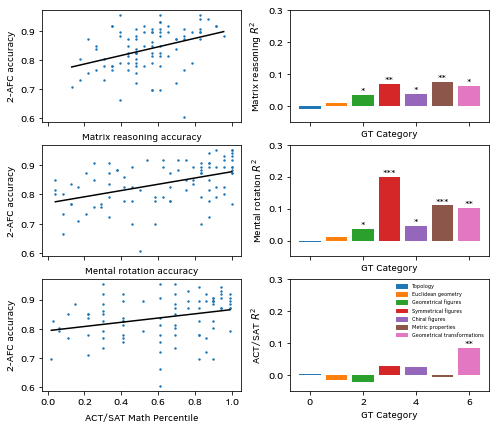

In [25]:
labels = {
    'mrt_accuracy': 'Mental rotation accuracy',
    'ucmrt_accuracy': 'Matrix reasoning accuracy',
    'geometry_accuracy': '2-AFC accuracy',
    'MathPercentile': 'ACT/SAT Math Percentile'
}

task_names = {
    'mrt_accuracy': 'Mental rotation',
    'ucmrt_accuracy': 'Matrix reasoning',
    'geometry_accuracy': '2-AFC',
    'MathPercentile': 'ACT/SAT'
}


def plot_scatter(predictor, ax):
    d = merged_us_data_by_part[(~merged_us_data_by_part[predictor].isna())]
    
    ax.scatter(d[predictor], d['geometry_accuracy'], s=2)
    x = d[predictor]
    y = d['geometry_accuracy']
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c="black")
    ax.set_xlabel(labels[predictor], labelpad=7)
    ax.set_ylabel(labels['geometry_accuracy'])
    return ax



def linear_regress_and_get_r2_and_pvalue(formula, data):
    result = smf.ols(f"geometry_accuracy ~ {formula}", data = data).fit()
    return result.rsquared_adj, result.f_pvalue

def get_r2_p_value_df_for_model(model):
    
    d = merged_us_data[~merged_us_data[model["key"]].isna()]
    
    def agg_func(df):
        r2, p = linear_regress_and_get_r2_and_pvalue(model["formula"], df)
        out = pd.DataFrame.from_dict({'Rsquared': [r2], 'p': [p]})
        return out
    
    grouped_by_cat_part = d.groupby(['paper_category', 'participant_number']).mean().reset_index()
    grouped_by_cat = grouped_by_cat_part.groupby('paper_category').apply(agg_func).reset_index()
    return grouped_by_cat

def bycatplot(model, ax):


    plotd = get_r2_p_value_df_for_model(model)
    ax.bar(range(len(plotd)), plotd['Rsquared'], color=cat_colors(plotd['paper_category']))
    ax.set_xlabel('GT Category')
    ax.set_ylabel(f"{task_names[model['key']]} $R^2$")
    ax.set_ylim(-0.05, 0.3)
    
    for i, p in enumerate(plotd['p']):
        if p < 0.05:
            if p < 0.001:
                text = "***"
            elif p < 0.01:
                text = "**"
            else:
                text = "*"
            ax.text(i, plotd['Rsquared'].iloc[i] + 0.001, text, ha='center')

fig, axes = plt.subplots(3, 2, figsize=(8, 7), sharex="col", sharey="col")


fig.subplots_adjust(hspace=0.2, wspace=0.25)

models = [
    {
        "key": "ucmrt_accuracy",
        "formula": "1 + ucmrt_accuracy"
    },
    {
        "key": "mrt_accuracy",
        "formula": "1 + mrt_accuracy"
    },
    {
        "key": "MathPercentile",
        "formula": "1 + MathPercentile + EnglishPercentile"
    }   
]


for i, predictor in enumerate(x["key"] for x in models):
    ax = axes[i][0]
    plot_scatter(predictor, ax)
    

for i, model in enumerate(models):
    bycatplot(model, axes[i][1])
    
legend_patches = []
for key, value in paper_category_colors_dict.items():
    legend_patches.append(matplotlib.patches.Patch(color=value, label=key))
    
axes[2][1].legend(handles=legend_patches, fontsize=5.5, frameon=False)

In [26]:
def calc_control_vs_exp_rt_difference(df):
    d = df.groupby('trial_type')[['rt', 'paper_category']].agg({'rt': 'mean', 'paper_category': 'first'}).reset_index()
    rt_diff = d[d['trial_type'] == "experimental"]['rt'].iloc[0] - d[d['trial_type'] == "control"]['rt'].iloc[0]
    accuracy = df.query('trial_type == "experimental"')['accuracy'].mean()
    
    return pd.Series({'rt_difference': rt_diff, 'paper_category': d['paper_category'].iloc[0], 'accuracy': accuracy})

rt_diff_data_raw = us_data_raw.groupby(['participant_number', 'paper_number']).apply(calc_control_vs_exp_rt_difference).reset_index()
rt_diff_data = rt_diff_data_raw.groupby('paper_number').agg(dict(paper_category='first', rt_difference='median', accuracy='mean')).reset_index()
rt_diff_data.head()

paper_number      paper_category  rt_difference  accuracy
0             3            Topology     -870.77875  0.977273
1             4            Topology     -221.25000  0.812500
2             5            Topology       95.23500  0.812500
3             6            Topology      -61.55250  0.687500
4             7  Euclidean geometry     -728.73875  0.960227

In [27]:
rt_data = us_data.groupby('paper_number').agg({'accuracy': 'mean', 'rt': 'median', 'paper_category': 'first'}).reset_index()
rt_data.head()

paper_number  accuracy         rt      paper_category
0             3  0.977273  1633.5000            Topology
1             4  0.812500  1765.3700            Topology
2             5  0.812500  1902.6375            Topology
3             6  0.687500  1904.5200            Topology
4             7  0.960227  1202.2575  Euclidean geometry

## RT

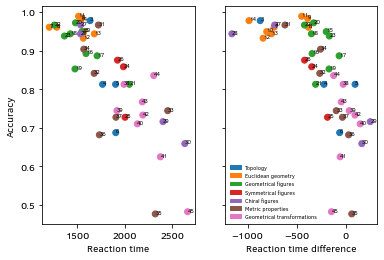

In [28]:
def rt_diff_items(ax):
    ax.scatter(rt_diff_data['rt_difference'], rt_diff_data['accuracy'], color=cat_colors(rt_diff_data['paper_category']))
    ax.set_xlabel('Reaction time difference')
    for i, number in enumerate(rt_diff_data['paper_number']):
        ax.annotate(str(number), (rt_diff_data['rt_difference'][i], rt_diff_data['accuracy'][i]), fontsize='xx-small')
    return ax

def rt_items(ax):
    ax.scatter(rt_data['rt'], rt_data['accuracy'], color=cat_colors(rt_data['paper_category']))
    for i, number in enumerate(rt_diff_data['paper_number']):
        ax.annotate(str(number), (rt_data['rt'][i], rt_data['accuracy'][i]), fontsize='xx-small')
    ax.set_xlabel('Reaction time')
    ax.set_ylabel('Accuracy')
    return ax

fig, ax = plt.subplots(1, 2, sharey=True)

rt_items(ax[0])
rt_diff_items(ax[1])
    
legend_patches = []
for key, value in paper_category_colors_dict.items():
    legend_patches.append(matplotlib.patches.Patch(color=value, label=key))
    
ax[1].legend(handles=legend_patches, fontsize=5.5, frameon=False)

## Between Category everything comparison

In [29]:
def with_normalized_col(df, colname, inverse=False):
    if np.min(df[colname]) < 0:
        without_min = df[colname] + -np.min(df[colname])
    else:
        without_min = df[colname] - np.min(df[colname])
    df = df.assign(**{colname: without_min / np.max(without_min)})
    if inverse:
        df[colname] = 1 - df[colname]
    return df




In [30]:
def group_quantile_filter_func(d, col):
    d = d.drop('paper_category', axis=1)
    d = d[d['rt_difference'] < d['rt_difference'].quantile(q=0.95)]
    return d


    
q95_per_group_rt_data = rt_diff_data_raw.groupby('paper_category').apply(group_quantile_filter_func, 'rt_difference').reset_index()
cat_rt_compare_df = with_normalized_col(q95_per_group_rt_data.groupby('paper_category').agg(dict(rt_difference='median')), 'rt_difference', inverse=True)
cat_rt_compare_df

rt_difference
paper_category                            
Chiral figures                    0.444218
Euclidean geometry                1.000000
Geometrical figures               0.372361
Geometrical transformations       0.000000
Metric properties                 0.254214
Symmetrical figures               0.485727
Topology                          0.429874

In [31]:
cat_accuracy_compare_df = with_normalized_col(us_data.groupby('paper_category').agg(dict(accuracy='mean')).reset_index(), 'accuracy')
cat_accuracy_compare_df

paper_category  accuracy
0                     Topology  0.438395
1           Euclidean geometry  1.000000
2          Geometrical figures  0.800700
3          Symmetrical figures  0.428844
4               Chiral figures  0.432665
5            Metric properties  0.198526
6  Geometrical transformations  0.000000

In [32]:
def tmp():
    dfs = [cat_rt_compare_df, cat_accuracy_compare_df]
    
    for model in models:
        df = get_r2_p_value_df_for_model(model)
        df = with_normalized_col(df, 'Rsquared', inverse=True)
        df = df.rename(columns=dict(Rsquared=model['key']))[['paper_category', model['key']]]
        dfs.append(df)
        
    master_df = dfs[0]
    
    for i in range(1, len(dfs)):
        master_df = master_df.merge(dfs[i], on="paper_category")
        
    return (master_df.melt(id_vars=['paper_category'], var_name='measure', value_name='score'))
    
cross_measure_scores = tmp()

cross_measure_scores.head()


paper_category        measure     score
0               Chiral figures  rt_difference  0.444218
1           Euclidean geometry  rt_difference  1.000000
2          Geometrical figures  rt_difference  0.372361
3  Geometrical transformations  rt_difference  0.000000
4            Metric properties  rt_difference  0.254214

Text(0.5, 0, 'Domain-specific                                                                                                    Domain-general')

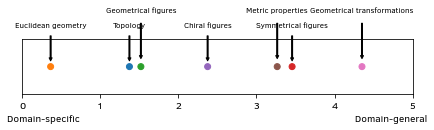

In [33]:
agg_scores = cross_measure_scores.groupby('paper_category').agg(dict(score='sum')).reset_index()
agg_scores['score'] = 5 - agg_scores['score']
fig, ax = plt.subplots(figsize=(7,1))
ax.scatter(agg_scores['score'], np.zeros_like(agg_scores['score']), c=cat_colors(agg_scores['paper_category']))
ax.set_xlim(0, 5)
for i in range(len(agg_scores['score'])):
    x = agg_scores['score'][i]
    y = 0
    paper_category = agg_scores['paper_category'][i]
    xtext = 0
    ytext = 0.08
    
    if paper_category == "Geometrical transformations":
        ytext = 0.11
    if paper_category == "Metric properties":
        ytext = 0.11
    if paper_category == "Geometrical figures":
        ytext = 0.11
    ax.annotate(paper_category, xy=(agg_scores['score'][i], 0), 
                xytext=(x + xtext, y + ytext), ha="center",
                arrowprops=dict(facecolor='black', shrink=0.15,
                                width=1, headwidth=3,
                                headlength=3),
                fontsize=8)
ax.set_yticks([])
ax.set_xlabel("Domain-specific" + " " * 100 + "Domain-general")
#ax.legend(handles=legend_patches, fontsize=5.5, frameon=False)

## Cross study

In [34]:
# Izard Adults

diapo_to_paper_number = pd.read_csv("diapo-to-paper-number.txt", sep=" ")

izard_adults = pd.read_csv("raw-izard-2009.txt", sep=" ")
izard_adults = izard_adults.merge(diapo_to_paper_number, on='Diapo')
izard_adults = izard_adults[~izard_adults['paper_number'].isin([1, 2])].dropna()
izard_adults.rename(columns={'Acc': 'accuracy'}, inplace=True)
# %>%
#   inner_join(diapo_to_paper_number, by = "Diapo") %>% 
#   filter(!(paper_number %in% c(1, 2))) %>% 
#   drop_na() # some trials seem to not have accuracy information
# izard_adults

izard_adults.head()

TrialNum  Subject CorResp  accuracy    Resp      RT  Diapo  Age_year  \
0        91     1000  Image3       1.0  Image3  4487.0     45        18   
1       147     1001  Image3       1.0  Image3  6063.0     45        22   
2       225     1002  Image3       1.0  Image3  7508.0     45        24   
3       538     1009  Image3       1.0  Image3  3832.0     45        23   
4       581     1010  Image3       1.0  Image3  5478.0     45        23   

   Gender  paper_number  
0  female            33  
1  female            33  
2  female            33  
3    male            33  
4  female            33

In [35]:
# Izard children

izard_children = pd.DataFrame.from_dict(dict(paper_number = range(1, 46), accuracy = [89.6, 87.5, 75.6, 40.4, 42.6, 41.7, 76.1, 33.3, 72.3, 59.6, 24.4, 60.4, 59.6, 43.8, 22.7, 45.7, 31.9, 62.5, 31.9, 34.8, 43.5, 61.7, 72.3, 19, 4.8, 31.9, 56.5, 72.3, 9.5, 4.5, 48.9, 36.2, 43.5, 69.6, 14.3, 18.2, 34.0, 29.8, 34.8, 14.3, 31.9, 10.0, 30.0, 28.6, 4.5])) 
izard_children = izard_children[~izard_children['paper_number'].isin([1, 2])]
izard_children.head()

paper_number  accuracy
2             3      75.6
3             4      40.4
4             5      42.6
5             6      41.7
6             7      76.1

In [36]:
# Dehaene
dehaene_paper_raw_percents = [95, 95, 93, 77, 68, 66, 93, 73, 100, 77, 66, 80, 93, 91, 77, 66, 77, 86, 73, 66, 77, 91, 95, 66, 50, 86, 86, 89, 23, 23, 93, 55, 45, 68, 48, 36, 86, 59, 52, 20, 41, 18, 25, 43, 18]

assert(len(dehaene_paper_raw_percents) == 45)

dehaene = pd.DataFrame.from_dict(dict(paper_number = range(1, 46) , accuracy = dehaene_paper_raw_percents))
dehaene = dehaene[~dehaene['paper_number'].isin([1, 2])]

In [37]:
studies = {
    'izard_children': izard_children,
    'izard_adults': izard_adults,
    'dehaene': dehaene,
    '2afc': us_data
}

def correlate(df1, df2):
    df1 = df1.groupby('paper_number').agg({'accuracy': 'mean'}).reset_index().sort_values('paper_number')
    df2 = df2.groupby('paper_number').agg({'accuracy': 'mean'}).reset_index().sort_values('paper_number')
    r, p = pearsonr(df1['accuracy'], df2['accuracy'])
    return r, p

import itertools

correlations = []
for stud1, stud2 in itertools.product(studies.keys(), studies.keys()):
    r, p = correlate(studies[stud1], studies[stud2])
    correlations.append(dict(stud1=stud1, stud2=stud2, r=r, p=p))
    
interstudy_comps = pd.DataFrame.from_records(correlations)
interstudy_comps.head()

stud1           stud2         r              p
0  izard_children  izard_children  1.000000  1.581010e-322
1  izard_children    izard_adults  0.640713   3.693665e-06
2  izard_children         dehaene  0.783882   5.089711e-10
3  izard_children            2afc  0.686092   3.813280e-07
4    izard_adults  izard_children  0.640713   3.693665e-06

In [38]:
interstudy_matrix = interstudy_comps.pivot(index="stud1", columns="stud2", values="r")
interstudy_pmatrix = interstudy_comps.pivot(index="stud1", columns="stud2", values="p")
interstudy_matrix.head()

stud2               2afc   dehaene  izard_adults  izard_children
stud1                                                           
2afc            1.000000  0.767138      0.716326        0.686092
dehaene         0.767138  1.000000      0.578069        0.783882
izard_adults    0.716326  0.578069      1.000000        0.640713
izard_children  0.686092  0.783882      0.640713        1.000000

In [39]:
study_names = {
    '2afc': '2-AFC',
    'izard_children': "Children\n(Izard et al., 2009)",
    "izard_adults": "Adults\n(Izard et al., 2009)",
    "dehaene": "Mundurucu\n(Dehaene et al., 2006)"
}



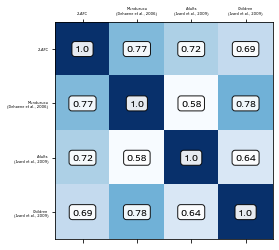

In [40]:
fig, ax = plt.subplots()
ax.matshow(interstudy_matrix, cmap=matplotlib.cm.get_cmap('Blues'))
ax.set_xticks(range(len(interstudy_matrix)))
ax.set_xticklabels(interstudy_matrix.index.map(study_names), rotation=0, fontsize=4)
ax.set_yticks(range(len(interstudy_matrix)))
ax.set_yticklabels(interstudy_matrix.index.map(study_names), rotation=0, fontsize=4)

for i in range(len(interstudy_matrix)):
    for j in range(len(interstudy_matrix)):
        ax.text(i, j, str(round(interstudy_matrix.iloc[i, j], 2)), ha='center', va='center', bbox={'facecolor': 'white', 'boxstyle': 'round', 'alpha': 0.9})

## Temporary

In [37]:
tmp = us_data.groupby(['participant_number', 'paper_category'])[['accuracy', 'rt']].mean().reset_index()
tmp.head()

participant_number       paper_category  accuracy           rt
0               50001             Topology  1.000000  3811.875000
1               50001   Euclidean geometry  1.000000  2394.750000
2               50001  Geometrical figures  1.000000  2249.277778
3               50001  Symmetrical figures  0.833333  4555.000000
4               50001       Chiral figures  0.750000  4300.875000

In [38]:
pivoted = tmp.pivot_table(index='participant_number', columns=['paper_category'])
pivoted.head()

accuracy                                         \
paper_category     Topology Euclidean geometry Geometrical figures   
participant_number                                                   
50001                 1.000             1.0000            1.000000   
50002                 1.000             0.9375            0.777778   
50003                 0.875             0.8125            0.666667   
50004                 0.500             0.6875            0.722222   
50005                 0.750             1.0000            0.833333   

                                                                         \
paper_category     Symmetrical figures Chiral figures Metric properties   
participant_number                                                        
50001                         0.833333          0.750          0.928571   
50002                         0.833333          1.000          0.571429   
50003                         0.666667          0.625          0.714286   
50004                         0.833333          0.875          0.500000   
50005                         0.333333          0.625          0.571429   

                                                         rt  \
paper_category     Geometrical transformations     Topology   
participant_number                                            
50001                                   0.6875  3811.875000   
50002                                   0.6875  4721.146250   
50003                                   0.6250   975.611250   
50004                                   0.6250   637.263750   
50005                                   0.6875  1655.333125   

                                                                               \
paper_category     Euclidean geometry Geometrical figures Symmetrical figures   
participant_number                                                              
50001                     2394.750000         2249.277778         4555.000000   
50002                     8792.102500         4626.908889         4057.341667   
50003                      989.480938          873.792500          869.961667   
50004                      708.356562          588.966667          583.121667   
50005                     1426.354375         1157.225556         1204.076667   

                                                     \
paper_category     Chiral figures Metric properties   
participant_number                                    
50001                 4300.875000       3015.214286   
50002                 3025.338750       6495.875000   
50003                  906.563125        927.156786   
50004                  776.976250        893.209286   
50005                 1166.705000       1808.130714   

                                                
paper_category     Geometrical transformations  
participant_number                              
50001                              4561.687500  
50002                             14584.066875  
50003                               960.561250  
50004                               756.648437  
50005                              1451.880313

In [39]:
pivoted.columns = (": ".join(x) for x in pivoted.columns.to_flat_index())

In [40]:
pivoted.head()

accuracy: Topology  accuracy: Euclidean geometry  \
participant_number                                                     
50001                            1.000                        1.0000   
50002                            1.000                        0.9375   
50003                            0.875                        0.8125   
50004                            0.500                        0.6875   
50005                            0.750                        1.0000   

                    accuracy: Geometrical figures  \
participant_number                                  
50001                                    1.000000   
50002                                    0.777778   
50003                                    0.666667   
50004                                    0.722222   
50005                                    0.833333   

                    accuracy: Symmetrical figures  accuracy: Chiral figures  \
participant_number                                                            
50001                                    0.833333                     0.750   
50002                                    0.833333                     1.000   
50003                                    0.666667                     0.625   
50004                                    0.833333                     0.875   
50005                                    0.333333                     0.625   

                    accuracy: Metric properties  \
participant_number                                
50001                                  0.928571   
50002                                  0.571429   
50003                                  0.714286   
50004                                  0.500000   
50005                                  0.571429   

                    accuracy: Geometrical transformations  rt: Topology  \
participant_number                                                        
50001                                              0.6875   3811.875000   
50002                                              0.6875   4721.146250   
50003                                              0.6250    975.611250   
50004                                              0.6250    637.263750   
50005                                              0.6875   1655.333125   

                    rt: Euclidean geometry  rt: Geometrical figures  \
participant_number                                                    
50001                          2394.750000              2249.277778   
50002                          8792.102500              4626.908889   
50003                           989.480938               873.792500   
50004                           708.356562               588.966667   
50005                          1426.354375              1157.225556   

                    rt: Symmetrical figures  rt: Chiral figures  \
participant_number                                                
50001                           4555.000000         4300.875000   
50002                           4057.341667         3025.338750   
50003                            869.961667          906.563125   
50004                            583.121667          776.976250   
50005                           1204.076667         1166.705000   

                    rt: Metric properties  rt: Geometrical transformations  
participant_number                                                          
50001                         3015.214286                      4561.687500  
50002                         6495.875000                     14584.066875  
50003                          927.156786                       960.561250  
50004                          893.209286                       756.648437  
50005                         1808.130714                      1451.880313

In [41]:
pivoted.to_csv('wide-analysis-csv.csv')
tmp.to_csv('long-analysis-csv.csv')